# Train Flooding-Filling model

We are going to use a two-phase training for this process. The fisrt one, using
`db01` pre-trains the model to expand a horizon annotation seed to a horizon segment.
The second step, will train the model using `db02` to track the horizons from
previously predicted segments.

In [1]:
%matplotlib notebook

import json
import os
import time
from typing import Tuple

import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from models.model_zoo import unet_tf2
import rockml.learning.keras.data_loaders as dl


In [2]:
def makedir(path: str):
    os.makedirs(path, mode=0o770, exist_ok=True)


class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, name='mean_iou', **kwargs):
        super(MeanIoU, self).__init__(name=name, **kwargs)
        self.tf_mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        self.tf_mean_iou.update_state(y_true, y_pred)

    def result(self):
        return self.tf_mean_iou.result()

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.tf_mean_iou.reset_states()


def training_loop(train_dataset: tf.data.Dataset,
                  val_dataset: tf.data.Dataset,
                  model: tf.keras.Model,
                  model_path: str,
                  optimizer: tf.keras.optimizers.Optimizer,
                  loss_fn: tf.keras.losses.Loss,
                  metrics: Tuple[dict, dict],
                  epochs: int,
                  loss_weight: float):
    train_metrics = metrics[0]
    val_metrics = metrics[1]

    # Iterate over epochs.
    best = 0.0
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))
        epoch_loss = 0
        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                logits = model(x_batch_train)
                pixel_loss = loss_fn(y_batch_train, logits)
                w = y_batch_train[:, :, :, -1] * loss_weight
                w = w + y_batch_train[:, :, :, 0]
                pixel_loss *= w
                loss_value = tf.reduce_sum(pixel_loss) * (
                        1. / y_batch_train.shape[0] / y_batch_train.shape[1] / y_batch_train.shape[2])

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            epoch_loss += loss_value

            # Update training metric.
            for metric in train_metrics.values():
                metric(y_batch_train, logits)

        print(f"Epoch loss: {epoch_loss / (step + 1)}")
        # Display metrics at the end of each epoch.
        for metric_name, metric in train_metrics.items():
            print(f"| {metric_name}: {metric.result()} ", end="", flush=True)
            metric.reset_states()
        print("|")

        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val)
            for metric in val_metrics.values():
                metric(y_batch_val, val_logits)

        metric_dict = {}
        for metric_name, metric in val_metrics.items():
            metric_dict[metric_name] = metric.result().numpy()
            print(f"| {metric_name}: {metric_dict[metric_name]} ", end="", flush=True)
            metric.reset_states()
        print("|")

        if best < metric_dict[metric_name]:
            model.save(os.path.join(params['model_path'], 'best.h5'), save_format='h5')

    return model


def load_db(params: dict, name_ext: str) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    with h5py.File(os.path.join(params['data_path'], f'train_db{name_ext}.hdf'), 'r') as train_h5_file:
        train_examples = len(train_h5_file.get('features'))
        train_dataset = tf.data.Dataset.from_tensor_slices(
            (np.array(train_h5_file.get('features')),
             tf.keras.utils.to_categorical(np.array(train_h5_file.get('label'))))
        )
        train_dataset = train_dataset.batch(batch_size=params['batch_size'])

    with h5py.File(os.path.join(params['data_path'], f'valid_db{name_ext}.hdf'), 'r') as valid_h5_file:
        valid_examples = len(valid_h5_file.get('features'))
        valid_dataset = tf.data.Dataset.from_tensor_slices(
            (np.array(valid_h5_file.get('features')),
             tf.keras.utils.to_categorical(np.array(valid_h5_file.get('label'))))
        )
        valid_dataset = valid_dataset.batch(batch_size=params['batch_size'])

    assert train_examples == params['dataset_info'][f'training_examples_db{name_ext}']
    assert valid_examples == params['dataset_info'][f'validation_examples_db{name_ext}']
    
    params['train_steps'] = train_examples / params['batch_size']
    params['valid_steps'] = valid_examples / params['batch_size']
    
    return train_dataset, valid_dataset



In [3]:
def plot_dataset(h5_dataset: h5py.File) -> None:
    in_0 = 0
    in_1 = 1
    lb_0 = 2
    numb = 10
    
    feats = h5_dataset.get('features')
    label = h5_dataset.get('label')
    
    fig, axeslist = plt.subplots(ncols=numb, nrows=3)
    for i in range(numb):
        db_idx = np.random.randint(len(h5_dataset))
        
        idx = in_0 * numb + i
        m = axeslist.ravel()[idx].imshow(feats[db_idx, :, :, 0], cmap=plt.hot())
        axeslist.ravel()[idx].set_axis_off()

        idx = in_1 * numb + i
        axeslist.ravel()[idx].imshow(feats[db_idx, :, :, 1], cmap=plt.gray())
        axeslist.ravel()[idx].set_axis_off()

        idx = lb_0 * numb + i
        axeslist.ravel()[idx].imshow(label[db_idx], cmap=plt.gray())
        axeslist.ravel()[idx].set_axis_off()


def plot_predictions(model: tf.keras.Model, inputs: np.ndarray, label: np.ndarray) -> None:
    preds = np.squeeze(phase1_model.predict(inputs))
    amax = np.amax(preds, axis=-1)
    argx = np.argmax(preds, axis=-1)

    fig, axeslist = plt.subplots(ncols=3, nrows=2)
    a_id = 0
    s_id = 1
    p0_id = 2
    p1_id = 3
    p_id = 4
    l_id = 5

    idx = a_id
    m = axeslist.ravel()[idx].imshow(feats[0, :, :, 0], cmap=plt.hot())
    axeslist.ravel()[idx].set_title('amplitudes')
    axeslist.ravel()[idx].set_axis_off()
    fig.colorbar(m, ax=axeslist.ravel()[idx])

    idx = s_id
    axeslist.ravel()[idx].imshow(feats[0, :, :, 1], cmap=plt.gray())
    axeslist.ravel()[idx].set_title('seed')
    axeslist.ravel()[idx].set_axis_off()

    idx = p_id
    axeslist.ravel()[idx].imshow(argx, cmap=plt.gray())
    axeslist.ravel()[idx].set_title('predictions')
    axeslist.ravel()[idx].set_axis_off()

    idx = p0_id
    m = axeslist.ravel()[idx].imshow(preds[:, :, 0], cmap=plt.hot())
    axeslist.ravel()[idx].set_title('preds_0')
    axeslist.ravel()[idx].set_axis_off()
    fig.colorbar(m, ax=axeslist.ravel()[idx])

    idx = p1_id
    m = axeslist.ravel()[idx].imshow(preds[:, :, 1], cmap=plt.hot())
    axeslist.ravel()[idx].set_title('preds_1')
    axeslist.ravel()[idx].set_axis_off()
    fig.colorbar(m, ax=axeslist.ravel()[idx])

    idx = l_id
    axeslist.ravel()[idx].imshow(label, cmap=plt.gray())
    axeslist.ravel()[idx].set_title('label')
    axeslist.ravel()[idx].set_axis_off()


In [4]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

params = dict()
params['data_path'] = '/home/sallesd/ffn_dataset'
params['model_path'] = '/home/sallesd/ffn_model'
params['batch_size'] = 512


<IPython.core.display.Javascript object>


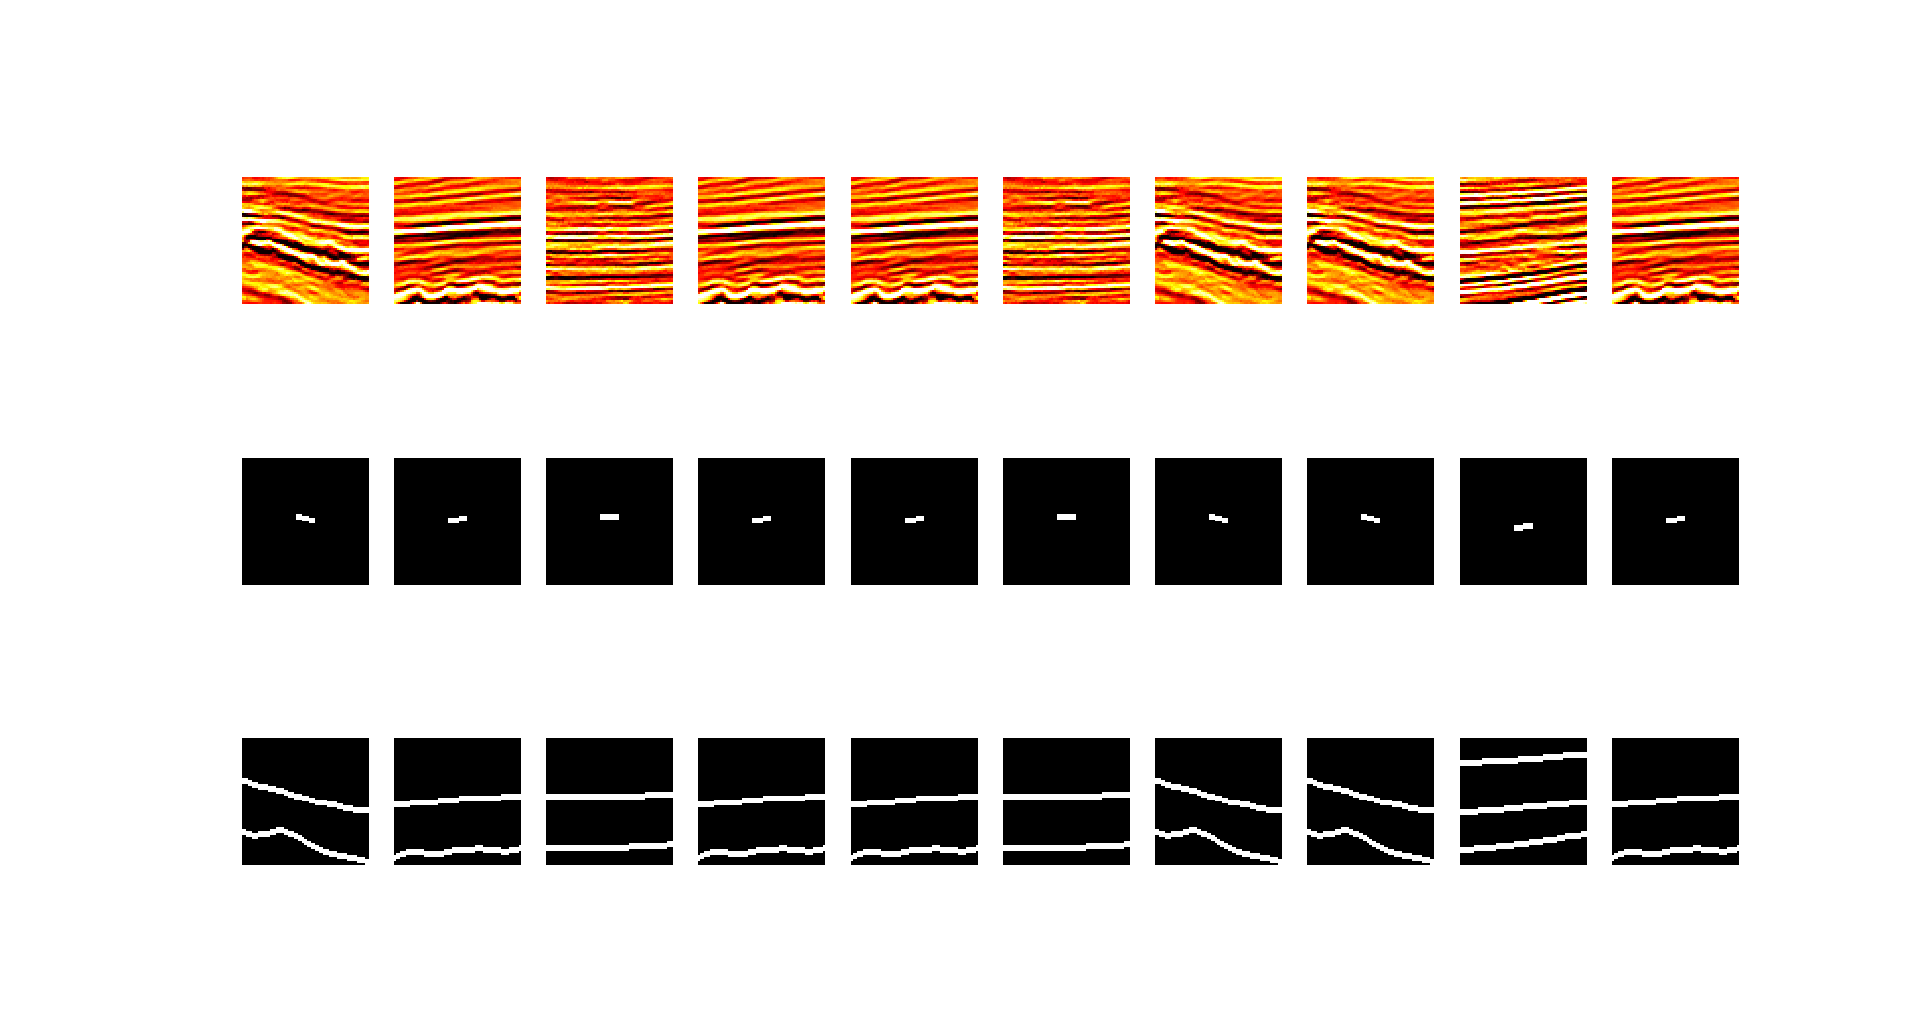

In [12]:
plot_dataset(h5_dataset=h5py.File(os.path.join(params['data_path'], 'valid_db01.hdf'), 'r'))

For now, we are using a manual loop for training, but the idea is to use RockML training mechanism.

## Training phase 1

In [6]:
params['dataset_info'] = json.load(open(os.path.join(params['data_path'], 'info.json')))

train_dataset, valid_dataset = load_db(params, name_ext='01')
    
params['num_classes'] = 2

print(f"Number of training examples: {params['dataset_info']['training_examples_db01']}")
print(f"Number of validation examples: {params['dataset_info']['validation_examples_db01']}")
print(f"Steps per training epoch: {params['train_steps']:.2f}")
print(f"Steps per validation epoch: {params['valid_steps']:.2f}")


Number of training examples: 15573
Number of validation examples: 1730
Steps per training epoch: 30.42
Steps per validation epoch: 3.38


In [7]:
makedir(params['model_path'])

train_metrics = {
    'train_mean_iou': MeanIoU(),
    'train_cat_acc': tf.keras.metrics.CategoricalAccuracy()
}
val_metrics = {
    'val_mean_iou': MeanIoU(),
    'val_cat_acc': tf.keras.metrics.CategoricalAccuracy()
}
metrics = (train_metrics, val_metrics)

start = time.time()

phase1_model = training_loop(
    train_dataset=train_dataset,
    val_dataset=valid_dataset,
    model=unet_tf2(input_shape=tuple(params['dataset_info']['tile_shape']), output_channels=params['num_classes']),
    model_path=params['model_path'],
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss_fn=tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE),
    metrics=(train_metrics, val_metrics),
    epochs=5,
    loss_weight=1.0 / params['dataset_info']['ones_db01']
)

params['trainig_time_01'] = time.time() - start
print(f"Total training time: {params['trainig_time_01']}")

phase1_model.save(os.path.join(params['model_path'], 'phase1_model.h5'), save_format='h5')


Start of epoch 0
Epoch loss: 0.9357327818870544
| train_mean_iou: 0.45261895656585693 | train_cat_acc: 0.7382174134254456 |
| val_mean_iou: 0.5443102717399597 | val_cat_acc: 0.8264549374580383 |
Start of epoch 1
Epoch loss: 0.5674883723258972
| train_mean_iou: 0.5919421911239624 | train_cat_acc: 0.8603253364562988 |
| val_mean_iou: 0.646181583404541 | val_cat_acc: 0.892082929611206 |
Start of epoch 2
Epoch loss: 0.34739163517951965
| train_mean_iou: 0.6726251244544983 | train_cat_acc: 0.9067424535751343 |
| val_mean_iou: 0.6823822259902954 | val_cat_acc: 0.909980297088623 |
Start of epoch 3
Epoch loss: 0.2689197063446045
| train_mean_iou: 0.7112780809402466 | train_cat_acc: 0.9247599840164185 |
| val_mean_iou: 0.7093396186828613 | val_cat_acc: 0.9225816130638123 |
Start of epoch 4
Epoch loss: 0.22582441568374634
| train_mean_iou: 0.7344271540641785 | train_cat_acc: 0.9342413544654846 |
| val_mean_iou: 0.7342907786369324 | val_cat_acc: 0.9335841536521912 |
Total training time: 76.738240

<IPython.core.display.Javascript object>


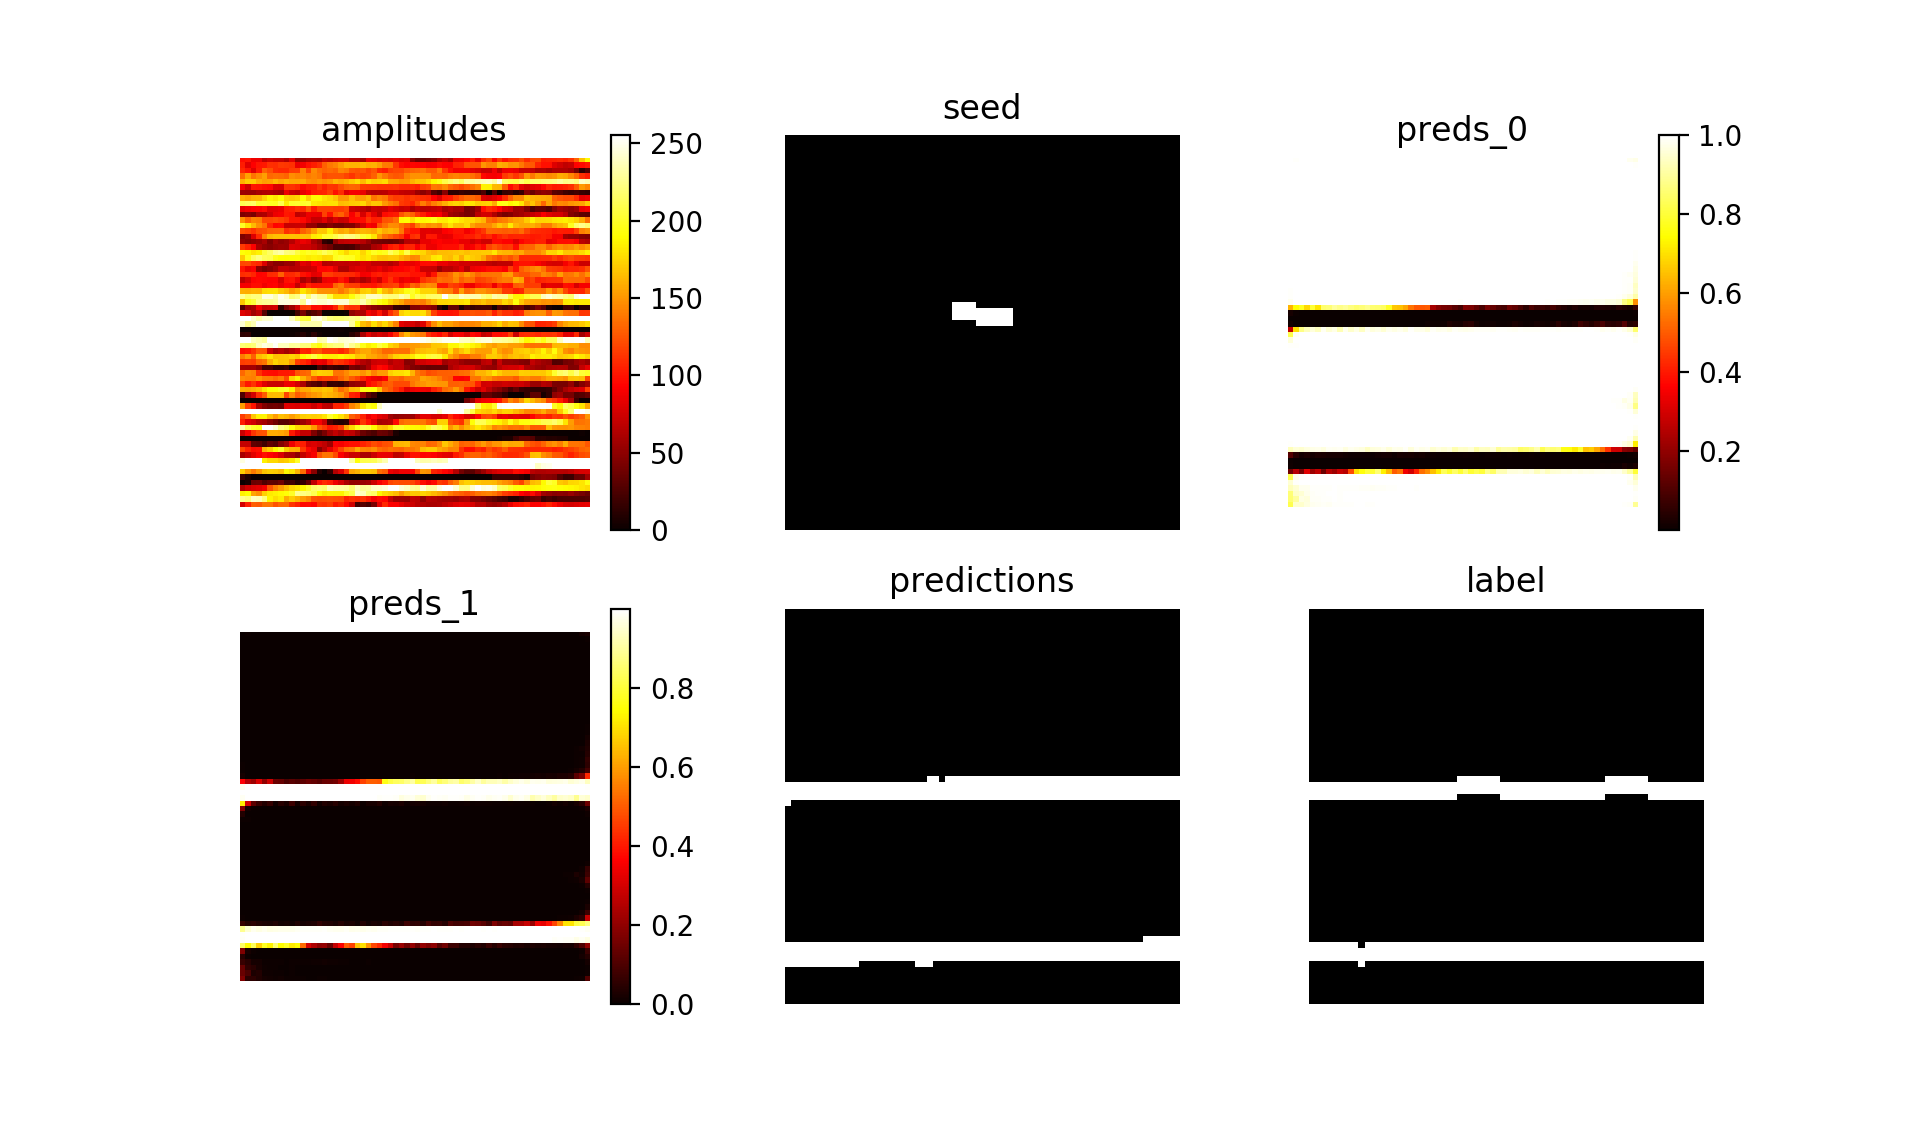

In [13]:
with h5py.File(os.path.join(params['data_path'], 'valid_db01.hdf'), 'r') as test_h5_file:
    feats = np.expand_dims(test_h5_file.get('features')[123], axis=0)
    label = test_h5_file.get('label')[123]

plot_predictions(phase1_model, feats, label)


## Training phase 2

In [9]:
train_dataset, valid_dataset = load_db(params, name_ext='02')

params['num_classes'] = 2

print(f"Number of training examples: {params['dataset_info']['training_examples_db02']}")
print(f"Number of validation examples: {params['dataset_info']['validation_examples_db02']}")
print(f"Steps per training epoch: {params['train_steps']:.2f}")
print(f"Steps per validation epoch: {params['valid_steps']:.2f}")

Number of training examples: 15573
Number of validation examples: 1730
Steps per training epoch: 30.42
Steps per validation epoch: 3.38


In [10]:
start = time.time()
phase2_model = training_loop(
    train_dataset=train_dataset,
    val_dataset=valid_dataset,
    model=tf.keras.models.load_model(os.path.join(params['model_path'], 'phase1_model.h5')),
    model_path=params['model_path'],
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss_fn=tf.keras.losses.CategoricalCrossentropy(
        reduction=tf.keras.losses.Reduction.NONE),
    metrics=(train_metrics, val_metrics),
    epochs=20,
    loss_weight=1.0 / params['dataset_info']['ones_db02']
)
phase2_model.save(os.path.join(params['model_path'], 'phase2_model.h5'))

print(f'Total training time: {time.time() - start}')


Start of epoch 0
Epoch loss: 0.499455064535141
| train_mean_iou: 0.6428176164627075 | train_cat_acc: 0.8924660086631775 |
| val_mean_iou: 0.7053972482681274 | val_cat_acc: 0.922174334526062 |
Start of epoch 1
Epoch loss: 0.250712126493454
| train_mean_iou: 0.7286987900733948 | train_cat_acc: 0.9323144555091858 |
| val_mean_iou: 0.7345132231712341 | val_cat_acc: 0.9342105984687805 |
Start of epoch 2
Epoch loss: 0.21342961490154266
| train_mean_iou: 0.7475986480712891 | train_cat_acc: 0.939433217048645 |
| val_mean_iou: 0.7499098181724548 | val_cat_acc: 0.9401832818984985 |
Start of epoch 3
Epoch loss: 0.19417351484298706
| train_mean_iou: 0.7603812217712402 | train_cat_acc: 0.944069504737854 |
| val_mean_iou: 0.7653997540473938 | val_cat_acc: 0.9459671378135681 |
Start of epoch 4
Epoch loss: 0.1787448674440384
| train_mean_iou: 0.772223711013794 | train_cat_acc: 0.9481847882270813 |
| val_mean_iou: 0.7741135358810425 | val_cat_acc: 0.9490012526512146 |
Start of epoch 5
Epoch loss: 0.164

<IPython.core.display.Javascript object>


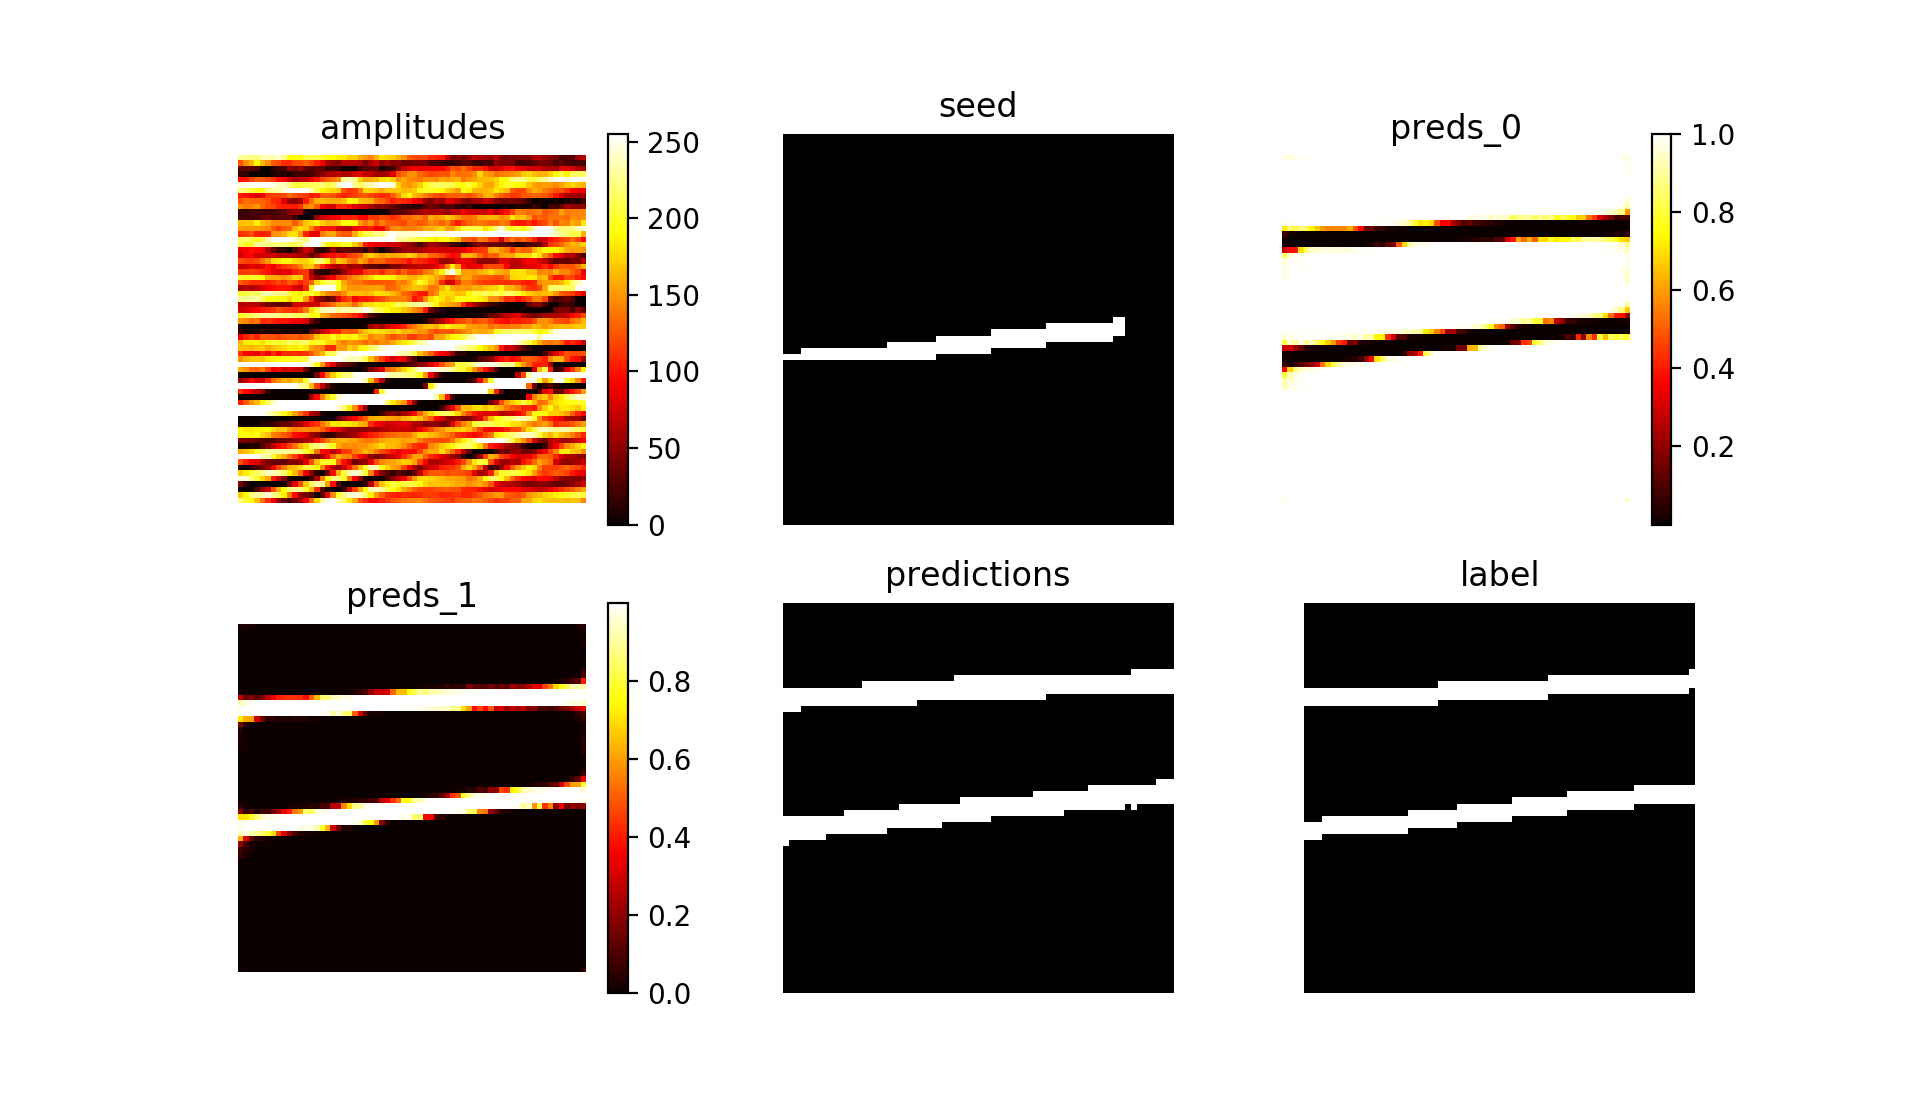

In [14]:
with h5py.File(os.path.join(params['data_path'], 'valid_db02.hdf'), 'r') as test_h5_file:
    feats = np.expand_dims(test_h5_file.get('features')[123], axis=0)
    label = test_h5_file.get('label')[123]

plot_predictions(phase1_model, feats, label) 


<IPython.core.display.Javascript object>


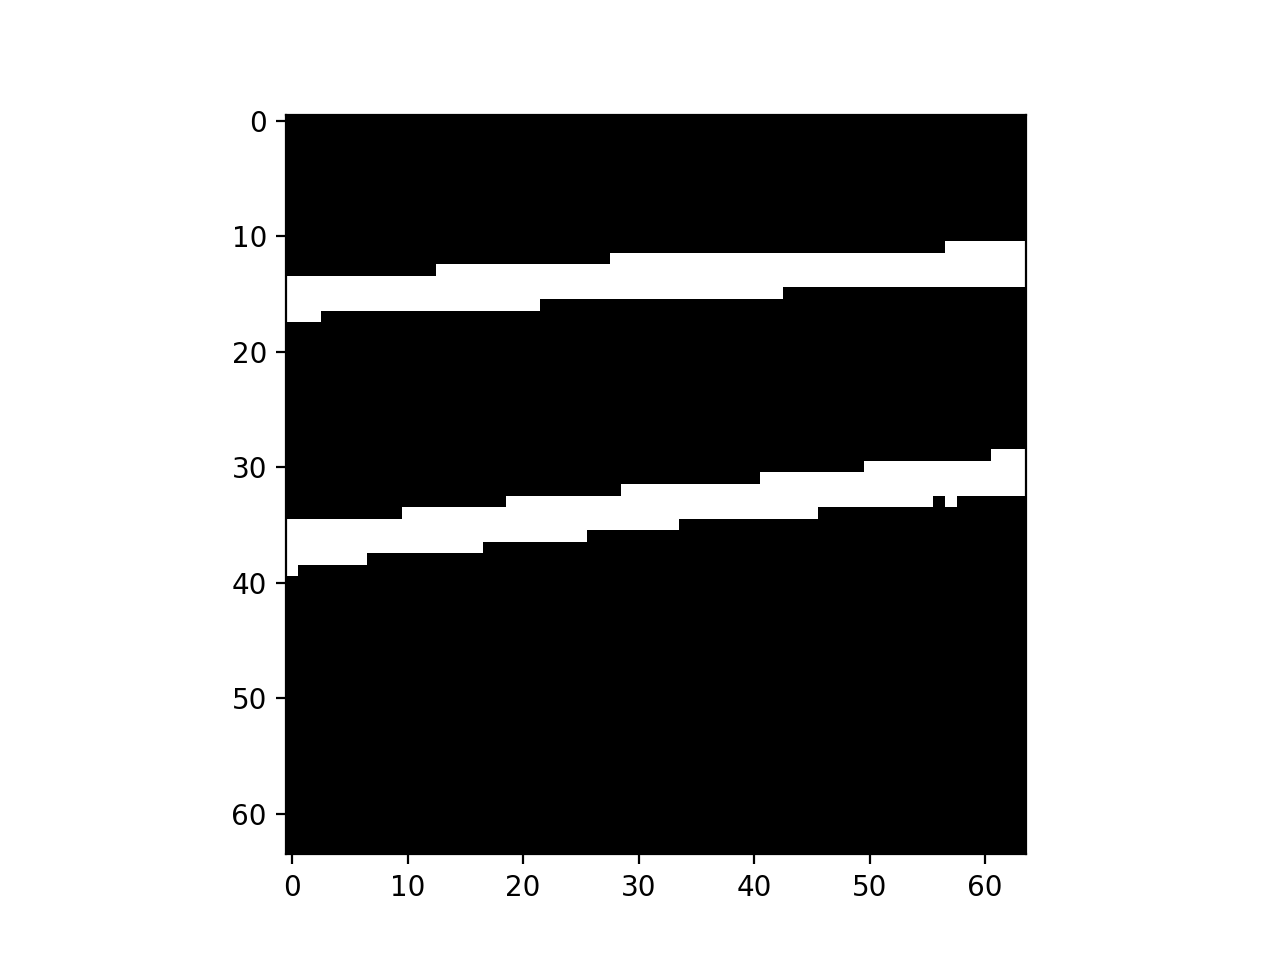

In [43]:
x0 = np.argmax(phase1_model.predict(feats), axis=-1) - 1
# x1 = (x0 + feats[0,:,:,1])[0]
# x0[:, :10] -= 1
plt.imshow(x0[0])

In [46]:
from skimage.graph import shortest_path

shortest_path(x0)

(array([[ 0, 39],
        [ 0, 38],
        [ 0, 38],
        [ 0, 38],
        [ 0, 38],
        [ 0, 38],
        [ 0, 38],
        [ 0, 37],
        [ 0, 37],
        [ 0, 37],
        [ 0, 37],
        [ 0, 37],
        [ 0, 37],
        [ 0, 37],
        [ 0, 37],
        [ 0, 37],
        [ 0, 37],
        [ 0, 36],
        [ 0, 36],
        [ 0, 36],
        [ 0, 36],
        [ 0, 36],
        [ 0, 36],
        [ 0, 36],
        [ 0, 36],
        [ 0, 36],
        [ 0, 35],
        [ 0, 35],
        [ 0, 35],
        [ 0, 35],
        [ 0, 35],
        [ 0, 35],
        [ 0, 35],
        [ 0, 35],
        [ 0, 34],
        [ 0, 34],
        [ 0, 34],
        [ 0, 34],
        [ 0, 34],
        [ 0, 34],
        [ 0, 34],
        [ 0, 34],
        [ 0, 34],
        [ 0, 34],
        [ 0, 34],
        [ 0, 34],
        [ 0, 33],
        [ 0, 33],
        [ 0, 33],
        [ 0, 33],
        [ 0, 33],
        [ 0, 33],
        [ 0, 33],
        [ 0, 33],
        [ 0, 33],
        [ 